<a href="https://colab.research.google.com/github/maiaufrrj/BRtrading/blob/main/MetaTrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pycaret

In [ ]:
#!pip install pandas --upgrade

In [335]:
import datetime as dt
from statsmodels.tsa.stattools import adfuller
#import yfinance as yf
#import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.model_selection as model_selection
from sklearn.model_selection import KFold
#import plotly.graph_objs as go
#import plotly.offline as ply
import pickle
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, TimeSeriesSplit
#from pycaret.regression import *
from pycaret.classification import *

In [349]:
filename = 'EURUSD_h1.pkl'
df = pickle.load(open(filename, 'rb'))

def MediaMovelSimples(DF,n):
    ''' função para calcular Média Móvel'''
    df = DF.copy()
    name='MM'+ str(n)  
    df[name] = df['close'].rolling(window=n, min_periods=1).mean()
    df.dropna(inplace=True) 
    return df
    
def DesvioPadrao(DF,n):
    ''' função para calcular Desvio Padrão'''
    df = DF.copy()
    name='STD'+ str(n)
    df[name] = df['close'].rolling(window=n, min_periods=1).std()
    df.dropna(inplace=True)  
    return df

def MediaMovelExponcial(DF,n):
    ''' função para calcular Desvio Padrão'''
    df = DF.copy()
    name='EWM'+ str(n)
    df[name] = df['close'].ewm(span=n).mean()
    df.dropna(inplace=True) 
    return df


 #ohlcv = pdr.get_data_yahoo(ticker,start,end)
    
def ATR(DF,n):
    '''função para calcular TR e ATR'''    
    df = DF.copy()
    name1='ATR'+ str(n)
    name2='TR' + str(n)
    df['H-L'] = abs(df['high']-df['low'])
    df['H-PC']= abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df[name2]=  df[['H-L','H-PC', 'L-PC']].max(axis=1,skipna=False)
    df[name1]= df[name2].rolling(n).mean()
    df = df.drop(['H-L','H-PC', 'L-PC'],axis=1)
    df.dropna(inplace=True) 
    return df
  
def BollBnd(DF,n):
    '''função para calcular Bandas de Bollinger''' 
    df = DF.copy()
    name1='BBsup'+ str(n)
    name2='BBinf'+ str(n)
    name3='BBlarg'+ str(n)
    df['MA'] = df['close'].rolling(n).mean()
    df[name1] = df['MA'] + 2*df['MA'].rolling(n).std()
    df[name2] = df['MA'] - 2*df['MA'].rolling(n).std()
    df[name3] = df[name1]-df[name2]
    df = df.drop(['MA'],axis=1)
    df.dropna(inplace=True)
    return df

def RSI(DF,n):
    '''função para calcular RSI (Índice de Força Relativa)''' 
    df = DF.copy()
    name='RSI'+ str(n)
    df['delta'] = df['close'] - df['close'].shift(1)
    df['gain'] = np.where(df['delta']>=0,df['delta'],0)
    df['loss'] = np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = [] 
    avg_loss = []
    gain = df['gain'].tolist()
    loss= df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i==n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i>n:
            avg_gain.append(((n-1)*avg_gain[i-1]+gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1]+loss[i])/n)   
    
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS']=df['avg_gain']/df['avg_loss']
    df[name]=100-(100/(1+df['RS']))
    df = df.drop(['delta','avg_gain','avg_loss','loss','gain','RS'],axis=1)
    df.dropna(inplace=True)  
    return df

   
def nIndicadores(DF,n):
    df=DF.copy()
    df = MediaMovelSimples(df,n)
    df = DesvioPadrao(df,n)
    df = MediaMovelExponcial(df,n)
    df = ATR(df,n)
    df = BollBnd(df,n)
    df = RSI(df,n)
    return df

lista=[5,7,9,20,120]
for n in lista:
    df=nIndicadores(df,n)

#del cl_price

'''CRIANDO VARIAVEL DE PREVISÃO (Y) '''

def Forecast(DF,n):
    '''Busca os n preços de fechamento a frente'''
    df = DF.copy()
    df['y']=df['close'].shift(-n)
    df.dropna(inplace=True)
    return df

def movimento_alta(DF,n,percentual_alta):
    '''Verifica se o preço de fechamento n períodos a frente é maior que um certo limite percentual (alta)'''
    df = DF.copy()
    df['delta'] = (df['close'].shift(-n) - df['close'])/df['close']
    df['alta'] = np.where(df['delta']>=percentual_alta,1,0)
    df = df.drop(['delta'],axis=1)
    df.dropna(inplace=True)  
    return df
    

#def movimento_baixa(DF,n,percentual_baixa):
    '''Verifica se o preço de fechamento n períodos a frente é menor que um certo limite percentual (alta)'''
#    df = DF.copy()
#    df['delta'] = (df['close'].shift(-n) - df['close'])/df['close']
#    df['baixa'] = np.where(df['delta']<=-percentual_baixa,1,0)
#    df = df.drop(['delta'],axis=1)
#    df.dropna(inplace=True)  
#    return df

def movimento_baixa(DF, baixa_esperada, periodos_frente):
    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
    df = DF.copy()

    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
    for i in range(periodos_frente):
      name='delta'+str(i)
      df[name] = (df['close'].shift(-i) - df['close'])/df['close']

    for i in range(periodos_frente):
      df['baixa'] = np.where(df['delta'+str(i)]<=-baixa_esperada,1,0)
    
    for i in range(periodos_frente):
      name='delta'+str(i)
      df = df.drop([name],axis=1)
  
    df.dropna(inplace=True)
    return df




def look_forward(DF, alta_esperada, periodos_frente):
    '''avalia n períodos à frente, se o valor máximo atinge a alta_esperada'''
    df = DF.copy()

    '''cria n colunas delta, uma para cada período a frente e calcula a diferença entre fechamento futuro e atual'''
    for i in range(periodos_frente):
      name='delta'+str(i)
      df[name] = (df['close'].shift(-i) - df['close'])/df['close']

    for i in range(periodos_frente):
      df['look_forward'] = np.where(df['delta'+str(i)]>=alta_esperada,1,0)
    
    for i in range(periodos_frente):
      name='delta'+str(i)
      df = df.drop([name],axis=1)
  
    df.dropna(inplace=True)
    return df


#definindo intervalo de previsão. n=1 >> previsão do período posterior
#df = Forecast(df,2)
baixa_esperada = 0.004
df = movimento_baixa(df,baixa_esperada,6)

percentual_alta = 0.004
alta_esperada = 0.004
df = look_forward(df,alta_esperada,6) #target
#df = movimento_alta(df,5,percentual_alta) #target

#print(f'altas: {df.alta.sum()}, baixas:{df.baixa.sum()}')

#definindo o target = alta
df['y']=df['look_forward']
del df['look_forward']


189

In [352]:
#def rename_target(DF,target):
#  df = DF.copy()
#  for i in range(df.columns):
#    df['y'] = df[target] 
#  if (df.columns[-1] == 'alta') | (df.columns[-1] == 'baixa'):
#    df = DF.copy()

#intialize the setup
separar=720 #separando 720hs de dataset (1 mês)
df_validacao = df.iloc[-separar:,:]

df_train = df.iloc[:-(separar-1),:]

X= df_train.iloc[:,:-1]  #da primeira à penultima (variáveis dependentes)
y= df_train.iloc[:,-1]    #ultima coluna (dados de previsão)


#exp_clf = setup(df_train, target = 'y', fold_strategy = 'timeseries', fold = 15, train_size=0.7, feature_selection = True, feature_selection_threshold = 0.70 ,session_id = 123)

#balanceamento SMOTE
exp_clf = setup(df_train,
                target = 'y', 
                fold_strategy = 'timeseries',
                fold = 15,
                train_size=0.7,
                feature_selection = True,
                fix_imbalance = True,
                feature_selection_threshold = 0.70,
                session_id = 123)

#transform_target = True ---item de regressao

,Description,Value
0,session_id,123
1,Target,y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8642, 54)"
5,Missing Values,False
6,Numeric Features,52
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [353]:
best = compare_models(sort = 'MCC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9781,0.7961,0.2515,0.4844,0.3058,0.2970,0.3227,0.7700
rf,Random Forest Classifier,0.9668,0.7987,0.2509,0.2647,0.2326,0.2175,0.2291,2.1920
lightgbm,Light Gradient Boosting Machine,0.9633,0.7845,0.2837,0.2241,0.2294,0.2122,0.2235,0.3313
gbc,Gradient Boosting Classifier,0.8891,0.7459,0.3945,0.0899,0.1316,0.1016,0.1392,3.2813
dt,Decision Tree Classifier,0.9257,0.6209,0.3016,0.1010,0.1434,0.1160,0.1383,0.2067
ada,Ada Boost Classifier,0.8414,0.7070,0.4195,0.0643,0.1016,0.0682,0.1078,0.7853
lda,Linear Discriminant Analysis,0.7400,0.6928,0.5359,0.0445,0.0810,0.0431,0.0907,0.0480
ridge,Ridge Classifier,0.7314,0.0000,0.5390,0.0439,0.0800,0.0421,0.0891,0.0320
lr,Logistic Regression,0.6268,0.6329,0.5648,0.0336,0.0627,0.0230,0.0587,0.1327
nb,Naive Bayes,0.2243,0.5695,0.8777,0.0249,0.0482,0.0062,0.0312,0.0327


In [355]:
#criando modelos
model = create_model('et')
model_tuned = tune_model(estimator = et,  fold = 15,  round = 4,  n_iter = 10,  optimize = 'MCC', verbose = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9365,0.7571,0.4000,0.0870,0.1429,0.1238,0.1643
1,0.9153,0.6792,0.2500,0.1667,0.2000,0.1572,0.1608
2,0.8651,0.7164,0.2000,0.0208,0.0377,0.0141,0.0254
3,0.8783,0.7204,0.4286,0.0667,0.1154,0.0861,0.1313
4,0.7989,0.5598,0.2000,0.0137,0.0256,0.0009,0.0020
5,0.8254,0.7698,0.6000,0.0882,0.1538,0.1129,0.1803
6,0.8492,0.8431,0.7500,0.1429,0.2400,0.1972,0.2834
7,0.8519,0.7154,0.5714,0.0702,0.1250,0.0952,0.1615
8,0.8307,0.6686,0.4000,0.0317,0.0588,0.0352,0.0725
9,0.8360,0.8689,0.6250,0.0781,0.1389,0.1052,0.1787


In [399]:
evaluate_model(model_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [411]:
# generate predictions on the original dataset
predictions_df = predict_model(model_tuned, data=df_train)
predictions_df = predictions_df.reset_index()

def alinhar_pontos(DF):
    '''cria uma coluna, em que o valor da Label será igual ao close*(1+percentual_alta) caso Label=1 '''
    df = DF.copy()
    df['Label'] = np.where(df['Label']==1,df['close'],0)
    df['baixa'] = np.where(df['baixa']==1,df['close'],0)
    return df

predictions_df = alinhar_pontos(predictions_df)

In [417]:
# line plot
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(predictions_df, x='time', y='close', template = 'plotly_dark')

#fig = go.Figure(data=[go.Candlestick(x=predictions_df['time'],
#                open=predictions_df['open'],
#                high=predictions_df['high'],
#                low=predictions_df['low'],
#                close=predictions_df['close'])])

fig.add_scatter(x=predictions_df['time'], y=predictions_df['Label'], mode='markers', marker_color='rgba(0, 255, 0, .8)')
fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['baixa'], mode='markers', marker_color='rgba(255, 0, 0, .8)')

ymin=predictions_df.close.min()
ymax=predictions_df.close.max()
fig.update_yaxes(range=[ymin, ymax])
fig.show()
fig.write_html("et_predicts_mcc.html")

In [ ]:
#! pip install backtrader

In [418]:
# testando dados no dataset de validação
predictions_df_teste = predict_model(model_tuned, data=df_validacao)
predictions_df_teste = predictions_df_teste.reset_index()

8

In [419]:
def alinhar_pontos(DF):
    '''cria uma coluna, em que o valor da Label será igual ao close*(1+percentual_alta) caso Label=1 '''
    df = DF.copy()
    df['Label'] = np.where(df['Label']==1,df['close'],0)
    #df = df.drop(['delta'],axis=1)
    #df.dropna(inplace=True)  
    return df

predictions_df_teste = alinhar_pontos(predictions_df_teste)


In [423]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(predictions_df_teste, x='time', y='close', template = 'plotly_dark')
fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['Label'], mode='markers', marker_color='rgba(0, 255, 0, .8)')
#fig.add_scatter(x=predictions_df_teste['time'], y=predictions_df_teste['baixa'], mode='markers', marker_color='rgba(255, 0, 0, .8)')

ymin=predictions_df_teste.close.min()
ymax=predictions_df_teste.close.max()
fig.update_yaxes(range=[ymin, ymax])

fig.show()
fig.write_html("et_valid_mcc.html")

In [ ]:
#!pip install bta-lib
#!pip install bt

In [381]:
import btalib as bta

#close = pd.DataFrame()
#close['sinal'] = df['close']
#close_bands = bta.bbands(close.sinal, period=20, devs=1.5).df

close = pd.DataFrame()
close['sinal'] = predictions_df['close']
close.set_index(predictions_df.time, inplace=True)

venda = pd.DataFrame()
venda['sinal'] =predictions_df['baixa']
venda['sinal'] = pd.to_numeric(venda['sinal'])
venda.fillna(0)

posicao = venda.copy()
posicao['sinal'] = predictions_df['Label']
posicao[venda == 1] = -1.0
posicao.set_index(predictions_df.time, inplace=True)

In [382]:
posicao.sinal.value_counts()

 0.00000    6804
-1.00000     181
 1.17448       4
 1.12432       4
 1.12418       4
            ... 
 1.12213       1
 1.12139       1
 1.12212       1
 1.12161       1
 1.19261       1
Name: sinal, Length: 1466, dtype: int64

In [ ]:
#close_bands.set_index(predictions_df.time, inplace=True)
#close_bands['top'].dropna(0);
#close_bands.info()
#close_bands.shape

#3. Criar estrutura de backtesting

In [ ]:
#https://pmorissette.github.io/bt/
#https://colab.research.google.com/drive/1K56P-z6RK01tLYSvfRVadxQGKUp7h7VO?usp=sharing#scrollTo=EepGT0mwt6ou

In [319]:
# download data
# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd
# a rolling mean is a moving average, right?
sma = df_train.close.rolling(5).mean()

In [393]:
import bt
et_strategy = bt.Strategy('et_strategy', [bt.algos.WeighTarget(posicao),
                                bt.algos.Rebalance()])

bteste = bt.Backtest(et_strategy, close)
resultado = bt.run(bteste)
resultado.display()

Stat                 et_strategy
-------------------  -------------
Start                2020-04-22
End                  2021-09-14
Risk-free rate       0.00%

Total Return         50.63%
Daily Sharpe         7.05
Daily Sortino        20.75
CAGR                 34.10%
Max Drawdown         -1.01%
Calmar Ratio         33.77

MTD                  0.00%
3m                   2.73%
6m                   5.92%
YTD                  8.67%
1Y                   15.40%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  34.10%

Daily Sharpe         7.05
Daily Sortino        20.75
Daily Mean (ann.)    28.62%
Daily Vol (ann.)     4.06%
Daily Skew           1.03
Daily Kurt           1.99
Best Day             1.21%
Worst Day            -0.67%

Monthly Sharpe       3.48
Monthly Sortino      inf
Monthly Mean (ann.)  28.18%
Monthly Vol (ann.)   8.11%
Monthly Skew         1.36
Monthly Kurt         0.73
Best Month           7.46%
Worst Month          0.00%

Yearly Sharp

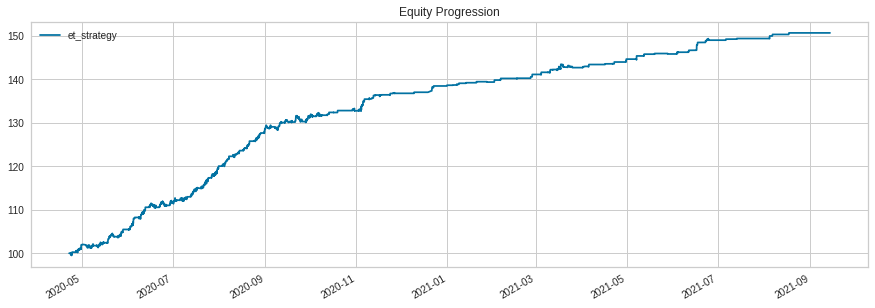

In [394]:
resultado.plot()

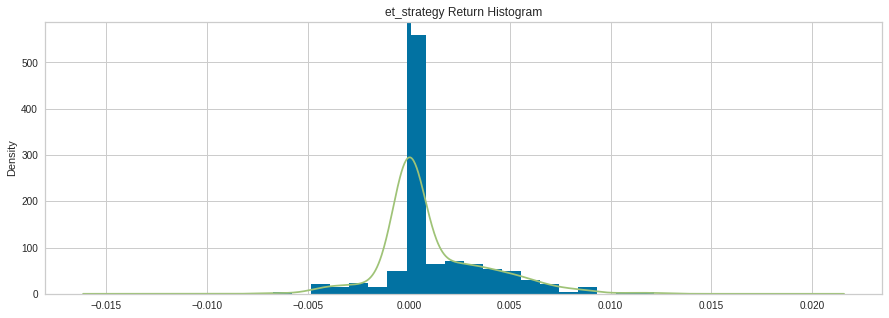

In [395]:
resultado.plot_histogram()

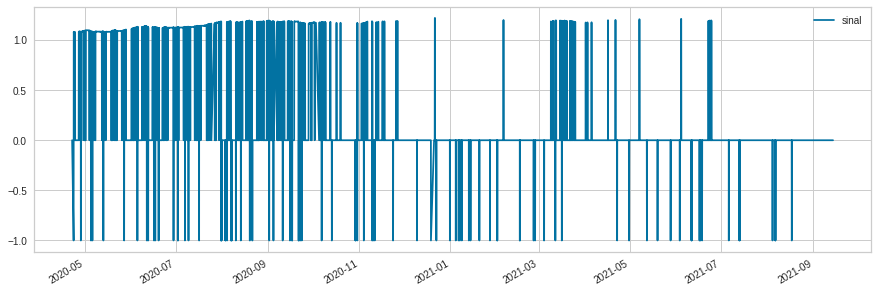

In [396]:
resultado.plot_security_weights()

In [397]:
# create our new strategy
s2 = bt.Strategy('s2', [bt.algos.RunDaily(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighInvVol(),
                        bt.algos.Rebalance()])

# now let's test it with the same data set. We will also compare it with our first backtest.
bteste2 = bt.Backtest(s2, close)
# we include test here to see the results side-by-side
resultado2 = bt.run(bteste, bteste2)
resultado2.display()

Stat                 et_strategy    s2
-------------------  -------------  ----------
Start                2020-04-22     2020-04-22
End                  2021-09-14     2021-09-14
Risk-free rate       0.00%          0.00%

Total Return         50.63%         9.05%
Daily Sharpe         7.05           1.04
Daily Sortino        20.75          1.85
CAGR                 34.10%         6.40%
Max Drawdown         -1.01%         -5.27%
Calmar Ratio         33.77          1.22

MTD                  0.00%          -0.00%
3m                   2.73%          -2.57%
6m                   5.92%          -1.20%
YTD                  8.67%          -3.34%
1Y                   15.40%         -0.47%
3Y (ann.)            -              -
5Y (ann.)            -              -
10Y (ann.)           -              -
Since Incep. (ann.)  34.10%         6.40%

Daily Sharpe         7.05           1.04
Daily Sortino        20.75          1.85
Daily Mean (ann.)    28.62%         6.21%
Daily Vol (ann.)     4.06%    

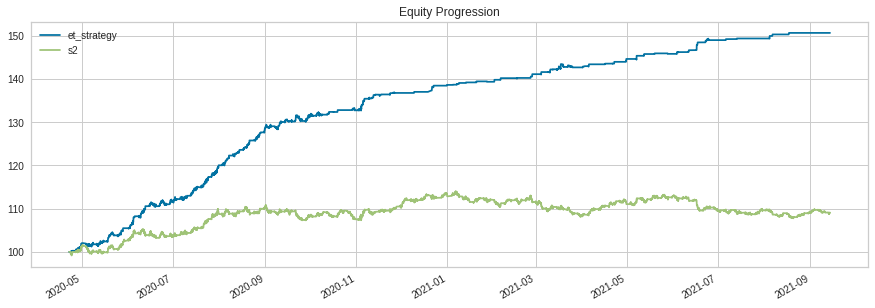

In [398]:
resultado2.plot()

In [426]:
#finalize a model
final_model = finalize_model(model_tuned)

In [427]:
#salvando modelo
import pickle
filename = 'et_tuned.pkl'
pickle.dump(final_model, open(filename, 'wb'))

In [425]:
model_tuned

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)